# Importing Necessary Libraries and Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [17]:
data = pd.read_csv('stock_data.csv')

In [18]:
data.head(10)

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,28/09/2018,234.05,235.95,230.20,233.50,233.75,3069914,7162.35
1,27/09/2018,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
2,26/09/2018,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
3,25/09/2018,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
4,24/09/2018,233.55,239.20,230.75,234.00,233.30,3423509,7999.55
5,21/09/2018,235.00,237.00,227.95,233.75,234.60,5395319,12589.59
6,19/09/2018,235.95,237.20,233.45,234.60,234.90,1362058,3202.78
7,18/09/2018,237.90,239.25,233.50,235.50,235.05,2614794,6163.70
8,17/09/2018,233.15,238.00,230.25,236.40,236.60,3170894,7445.41
9,14/09/2018,223.45,236.70,223.30,234.00,233.95,6377909,14784.50


In [19]:
data_open = data.reset_index()['High']
data_open

0       235.95
1       236.80
2       240.00
3       236.75
4       239.20
         ...  
2030    119.50
2031    121.00
2032    121.95
2033    122.00
2034    123.00
Name: High, Length: 2035, dtype: float64

# Data Analysis And Preprocessing

In [21]:
data_open.shape

(2035,)

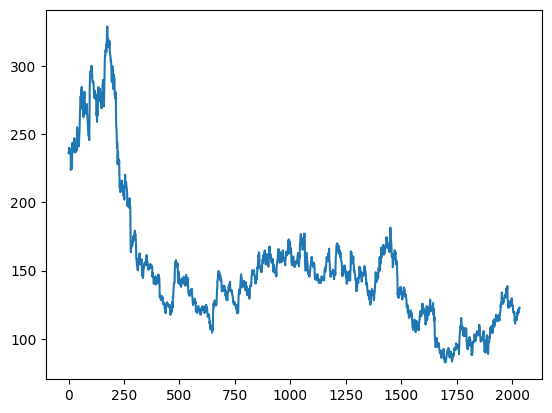

In [22]:
plt.plot(data_open)

In [24]:
# scaling the data using minmax scaler

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))
data_open = scaler.fit_transform(np.array(data_open).reshape(-1,1))

data_open.shape

(2035, 1)

In [25]:
data_open

array([[0.62268754],
       [0.62614353],
       [0.6391543 ],
       ...,
       [0.15917869],
       [0.15938199],
       [0.16344786]])

# Splitting Data for Testing And Training

Here, we have time series data , so we cannot used random seed to split our data.

In [26]:
train = int(len(data_open)*0.70)
test = len(data_open)-train
train_data , test_data = data_open[0:train,:],data_open[train:len(data_open),:1]

In [28]:
print("Training data size is : ", train)
print("Test data size is : ", test)

Training data size is :  1424
Test data size is :  611


In [34]:
def back_test(dataset , time_step=1):
  Xdata, Ydata = [],[]
  for i in range(len(dataset)-time_step-1):
    a = dataset[i:(i+time_step),0]
    Xdata.append(a)
    Ydata.append(dataset[i+time_step , 0])
  return np.array(Xdata) , np.array(Ydata)

In [35]:
time_step  = 100
X_train, y_train = back_test(train_data, time_step)
X_test, y_test = back_test(test_data, time_step)

In [38]:
X_test.shape

(510, 100)

In [41]:
# reshaping the training and testing data

X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

X_test.shape

(510, 100, 1)

# Creating the LTSM Model

In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [46]:
model = Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',  optimizer = 'adam')

In [47]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100, 50)           10400     
                                                                 
 lstm_4 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [49]:
model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=100, batch_size=64, verbose = 1)

Epoch 1/100
21/21 [==============================] - 16s 444ms/step - loss: 0.0215 - val_loss: 0.0089
Epoch 2/100
21/21 [==============================] - 6s 254ms/step - loss: 0.0027 - val_loss: 6.9763e-04
Epoch 3/100
21/21 [==============================] - 4s 192ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 4/100
21/21 [==============================] - 6s 273ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 5/100
21/21 [==============================] - 5s 217ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 6/100
21/21 [==============================] - 4s 189ms/step - loss: 0.0014 - val_loss: 9.2782e-04
Epoch 7/100
21/21 [==============================] - 4s 205ms/step - loss: 0.0012 - val_loss: 8.2406e-04
Epoch 8/100
21/21 [==============================] - 4s 210ms/step - loss: 0.0012 - val_loss: 7.9146e-04
Epoch 9/100
21/21 [==============================] - 4s 181ms/step - loss: 0.0011 - val_loss: 7.4381e-04
Epoch 10/100
21/21 [==============================] - 5s 245ms/step - 

In [50]:
import tensorflow as tf

In [51]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

16/16 [==============================] - 1s 58ms/step


In [52]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [53]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train, train_predict))

166.6194155818111

In [55]:
math.sqrt(mean_squared_error(y_test, test_predict))

110.26455612671872

# Plotting the Predicted And Actual Data

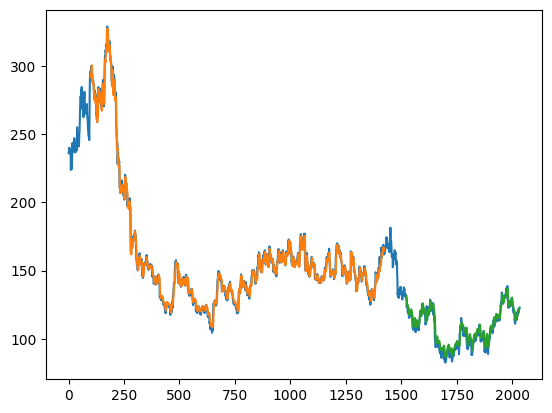

In [60]:
#shoft train predictions for plotting
lookback = 100
trainPredictPlot = np.empty_like(data_open)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[lookback:len(train_predict)+lookback,:] = train_predict

#shift test predictions for plotting
testPredictPlot = np.empty_like(data_open)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict)+(lookback*2)+1:len(data_open)-1,:] = test_predict

#plot the baseline and predictions
plt.plot(scaler.inverse_transform(data_open))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()